# Exercise 6.6 Analyzing Time Series Data

## 1. Import libraries, set system path, and load data

In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [6]:
# Set system path
path =r'C:\Users\Stony\OneDrive\CareerFoundry\Data Immersion Course\Achievement 6\Covid Analysis'

In [7]:
# Import dataset into df_covid_19 dataframe
df_covid_19 = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'Cleaned_Conditions_Contributing_to_COVID-19_Deaths.csv'))

In [8]:
# Validate dataset was loaded correctly into dataframe
print(df_covid_19.head())
print(df_covid_19.info())
df_covid_19.shape

   Data As Of  Start Date    End Date    Year  Month    State  \
0  2023-09-24  2020-01-01  2020-01-31  2020.0    1.0  Alabama   
1  2023-09-24  2020-02-01  2020-02-29  2020.0    2.0  Alabama   
2  2023-09-24  2020-03-01  2020-03-31  2020.0    3.0  Alabama   
3  2023-09-24  2020-04-01  2020-04-30  2020.0    4.0  Alabama   
4  2023-09-24  2020-05-01  2020-05-31  2020.0    5.0  Alabama   

        Condition Group                Condition ICD10_codes Age Group  \
0  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
1  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
2  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
3  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   
4  Respiratory diseases  Influenza and pneumonia     J09-J18      0-24   

   COVID-19 Deaths  Number of Mentions Flag  
0              0.0                 0.0  NaN  
1              0.0                 0.0  NaN  
2              0.0        

(430560, 13)

## 2. Subsetting, Wrangling, and Cleaning Data

I was unable to locate any data on the Quandl website and since our combined dataset already has time series we can use for our analyses, I will use the existing data I have to perform the time series analysis.

The first step is to convert the Year and Month columns to integer types, followed by creating a new column called Date which will be used to aggregate the Covid-19 mortality and number of mentions by summing the data points by month.

In [11]:
# Converting Year and Month to integers and create a new column called Date
df_covid_19['Year'] = df_covid_19['Year'].astype(int)
df_covid_19['Month'] = df_covid_19['Month'].astype(int)
df_covid_19['Date'] = pd.to_datetime(df_covid_19[['Year', 'Month']].assign(DAY=1))

In [12]:
# Validate our changes were successful
print(df_covid_19[['Year', 'Month', 'Date']].head())

   Year  Month       Date
0  2020      1 2020-01-01
1  2020      2 2020-02-01
2  2020      3 2020-03-01
3  2020      4 2020-04-01
4  2020      5 2020-05-01


In [13]:
# Aggregate the data my month using the sum of Covid mortality and number of mentions
monthly_data = df_covid_19.groupby(['Date']).agg({'Number of Mentions': 'sum', 'COVID-19 Deaths': 'sum'}).reset_index()

In [14]:
# Validate the data aggregation
print(monthly_data.head())

        Date  Number of Mentions  COVID-19 Deaths
0 2020-01-01               144.0            107.0
1 2020-02-01               337.0            346.0
2 2020-03-01             31957.0          31230.0
3 2020-04-01            243257.0         232279.0
4 2020-05-01            152543.0         144114.0


## Create a Line chart of our data

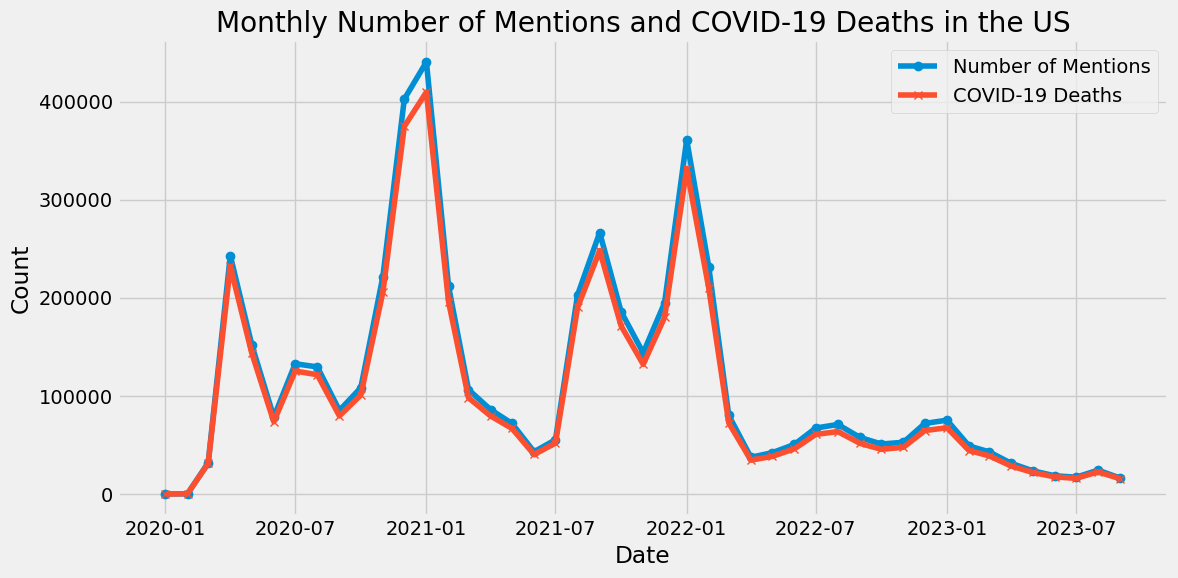

In [64]:
# Create a line chart using Number of mentions and Covid-19 deaths
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Date'], monthly_data['Number of Mentions'], marker='o', label='Number of Mentions')
plt.plot(monthly_data['Date'], monthly_data['COVID-19 Deaths'], marker='x', label='COVID-19 Deaths')
plt.title('Monthly Number of Mentions and COVID-19 Deaths in the US')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Export the line chart
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'monthly_mentions_deaths_line.png')
plt.savefig(file_name)
plt.show()

Our line chart shows significant flucuations in both Covid-19 mortality and Number of mentions with notable peaks during the winter months.

## 4. Decomposing the data's components

We will decompose the time-series data for both Covid 19 mortality and number of mentions into trend, seasonality, and noise or residuals.

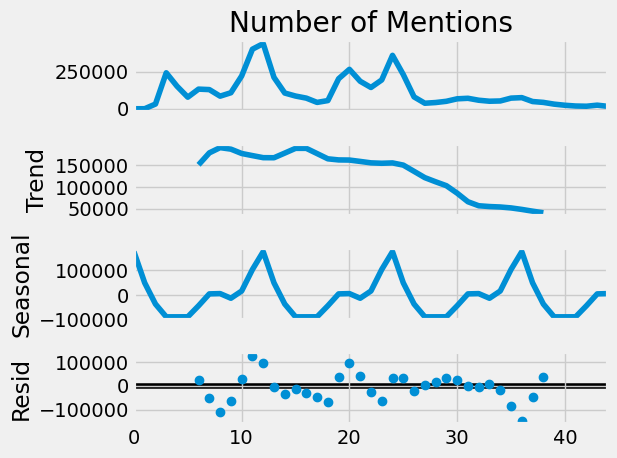

In [54]:
# Decompose the data component for Number of mentions
result_mentions = seasonal_decompose(monthly_data['Number of Mentions'], model='additive', period=12)
result_mentions.plot()

# Export the visualization
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_number_of_mentions.png')
plt.savefig(file_name)
plt.show()

Analyzing the decomposition, there is a clear trend of an increase followed by a decrease over time. The seasonal chart highlights periodic fluctuations, and the noise or residuals appear to be relatively random in nature. This could indicate that most patterns in our data are captured by trend and seasonality.

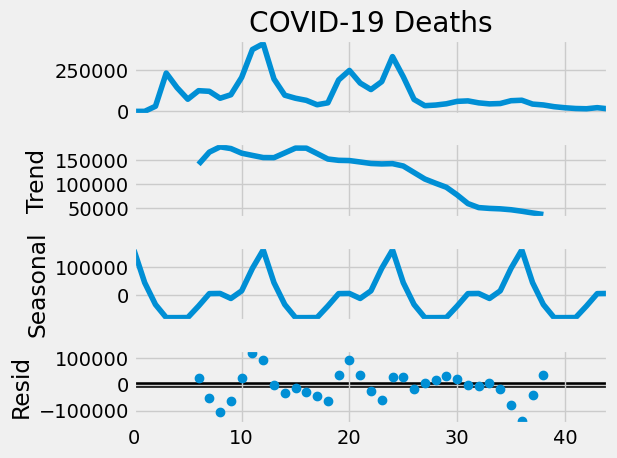

In [56]:
# Decompose the data's components for COvid-19 mortality
result_deaths = seasonal_decompose(monthly_data['COVID-19 Deaths'], model='additive', period=12)
result_deaths.plot()

# Export the visualization
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'decomposition_covid_deaths.png')
plt.savefig(file_name)

plt.show()

The decomposition of Covid mortality shows a very similar pattern to number of mentions. There is a clear trend and obvious seasonal component to the data, and the noise appears to be random in nature.

## 5. Dickey-Fuller Test to check for stationarity

In [25]:
# Create a function to conduct the Dickey-Fuller test
def check_stationarity(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value', result[1])
    if result[1] > 0.05:
        return False
    else:
        return True

In [26]:
# Check for stationarity in both time series
stationary_mentions = check_stationarity(monthly_data['Number of Mentions'])
stationary_deaths = check_stationarity(monthly_data['COVID-19 Deaths'])

ADF Statistic: -2.4112829695826288
p-value 0.1385771647786353
ADF Statistic: -2.408304314893017
p-value 0.13940628216712408


Reviewing the results of the Dickey-Fuller test, the p-values for both number of mentions and covid mortality are greater than 0.05, with the p=values being 0.1386 and 0.1394 respectively. This means that we fail to prove the null hypothesis and that our data is not stationary and will require differencing to stabilize the mean.

## 6. Differencing the data

In [29]:
# Applying differencing to number of mentions
if not stationary_mentions:
    monthly_data['Number of Mentions Diff'] = monthly_data['Number of Mentions'].diff().dropna()
    stationary_mentions = check_stationarity(monthly_data['Number of Mentions Diff'].dropna())

ADF Statistic: -3.6882761042634873
p-value 0.0042811161589802705


In [30]:
# Applying differencing to Covid-19 mortality
if not stationary_deaths:
    monthly_data['COVID-19 Deaths Diff'] = monthly_data['COVID-19 Deaths'].diff().dropna()
    stationary_deaths = check_stationarity(monthly_data['COVID-19 Deaths Diff'].dropna())

ADF Statistic: -3.6882351272693943
p-value 0.004281714045715767


After applying differencing to our data, we see significant improvement to the Dickey-Fuller test results. Both p-values are less than 0.05, which allows us to reject the null hypothesis of non-stationarity. This means our data is now stationary and suitable for time-series modeling.

## 7. Check for autocorrelation

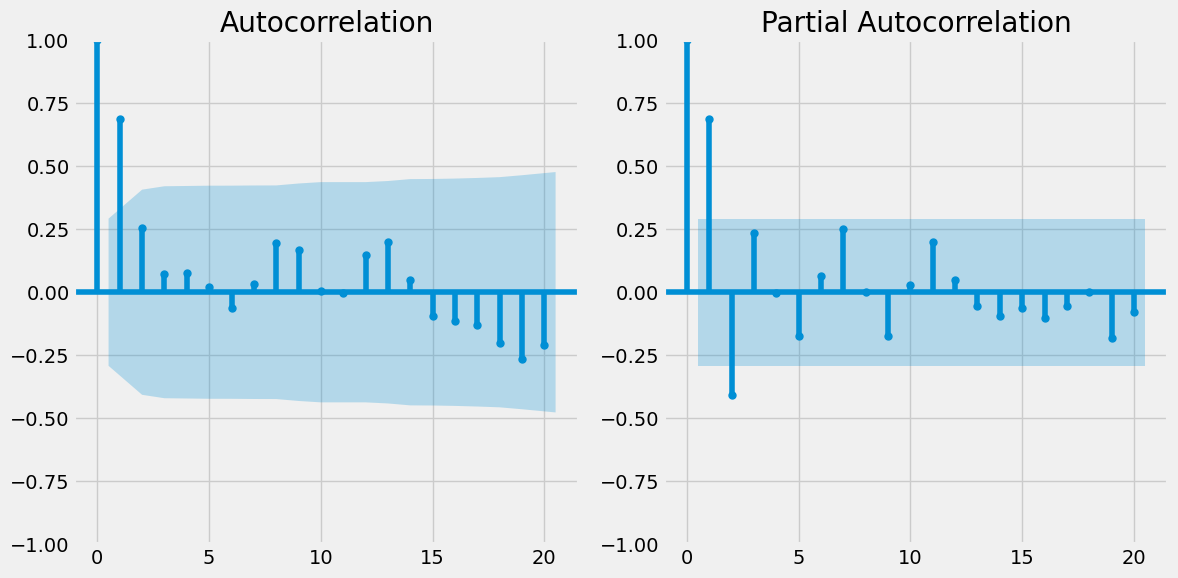

In [58]:
# Plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) for number of mentions
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_data['Number of Mentions'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation')
plt.subplot(122)
plot_pacf(monthly_data['Number of Mentions'].dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.tight_layout()

# Export the autocorrelation visualization
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'autocorrelation_number_of_mentions.png')
plt.savefig(file_name)
plt.show()

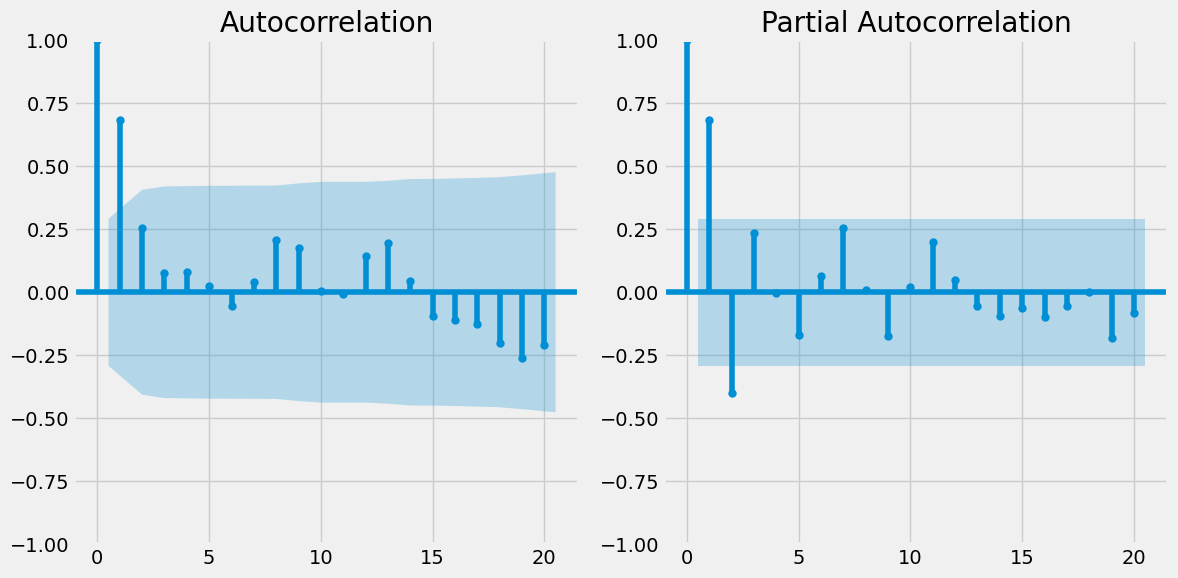

In [62]:
# Plot the ACF and the PACF for COVID-19 Deaths
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_data['COVID-19 Deaths'].dropna(), lags=20, ax=plt.gca())
plt.title('Autocorrelation')
plt.subplot(122)
plot_pacf(monthly_data['COVID-19 Deaths'].dropna(), lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation')
plt.tight_layout()

# Export the scatterplot of clusters
file_name = os.path.join(path, '04 Analysis', 'Visualizations', 'autocorrelation_covid_deaths.png')
plt.savefig(file_name)

plt.show()

There are only a small number of lags remaining, so further differencing is not necessary. Both the ACF and PACF plots for both Covid mortality and number of mentions show significant autocorrelations at lag 1. This could suggest that an ARIMA model with parameters of p = 1, d = 1, and q = 1 could be suitable for modeling Covid deaths and number of mentions.